<a href="https://colab.research.google.com/github/utkarshtambe10/Potato-Disease-Classification/blob/main/Potato_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#Importing Datasets

In [ ]:
#downloading/importing datasets from google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#Importing Required Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import cv2

#Visualizing Dataset

In [ ]:
#defining various terms
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
#loading dataset according to our own requirements
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Potato_Leaf_Dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [ ]:
#printing the names of different folders
class_names = dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
#for, image specifications
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)


(32, 256, 256, 3)


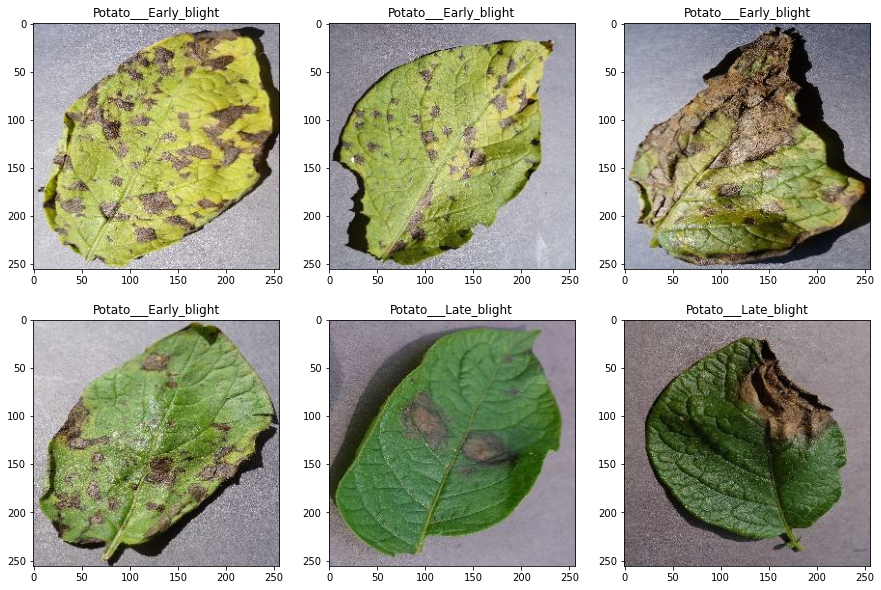

In [ ]:
plt.figure(figsize=(15, 10))

for image_batch, label_batch in dataset.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])


#Splitting the Dataset (Train and Test)

Splitting the dataset into training and testing if not available already (OPTIONAL)
* 70% for training
* 15% for validation
* 15% for testing

In [ ]:
train_size = 0.7
len(dataset) * train_size


47.599999999999994

In [ ]:
train_dataset = dataset.take(48)
len(train_dataset)


48

In [ ]:
test_dataset = dataset.skip(48)  #skip first 48 batches of the images
len(test_dataset)


20

In [ ]:
validation_size = 0.15
len(dataset) * validation_size

10.2

In [ ]:
validation_dataset = test_dataset.skip(10)
len(validation_dataset)


10

In [ ]:
#partitioning dataset
def get_dataset_partition_tf(dataset, train_split = 0.7, validation_split = 0.15, test_split = 0.15, shuffle = True, shuffle_size = 10000):
  dataset_size = len(dataset)

  if shuffle:
    dataset = dataset.shuffle(shuffle_size, seed = 18)
  
  train_size = int(train_split * dataset_size)
  validation_size = int(validation_split * dataset_size)

  train_dataset = dataset.take(train_size)
  validation_dataset = dataset.skip(train_size).take(validation_size)
  test_dataset = dataset.skip(train_size).skip(validation_size)
  
  return train_dataset, validation_dataset, test_dataset


In [ ]:
train_dataset, validation_dataset, test_dataset = get_dataset_partition_tf(dataset)


In [ ]:
len(train_dataset) 

47

In [ ]:
len(validation_dataset) 

10

In [ ]:
len(test_dataset)

11

In [ ]:
#for, increasing system performance while training
#prefetch() - loads next batch of images into CPU when GPU is busy training images
#cache() - saves time while reading images
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


#Preprocessing of Images

Resizing and Rescaling

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])


Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


#Model Building

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])
model.build(input_shape = input_shape)


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)


In [ ]:
history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = validation_dataset
)


Epoch 1/50
47/47 [==============================] - 140s 107ms/step - loss: 0.9173 - accuracy: 0.4858 - val_loss: 0.9354 - val_accuracy: 0.4723
Epoch 2/50
47/47 [==============================] - 5s 97ms/step - loss: 0.8291 - accuracy: 0.5831 - val_loss: 0.9861 - val_accuracy: 0.6014
Epoch 3/50
47/47 [==============================] - 5s 97ms/step - loss: 0.4856 - accuracy: 0.8128 - val_loss: 0.4493 - val_accuracy: 0.8243
Epoch 4/50
47/47 [==============================] - 5s 98ms/step - loss: 0.3320 - accuracy: 0.8561 - val_loss: 0.3369 - val_accuracy: 0.8541
Epoch 5/50
47/47 [==============================] - 5s 97ms/step - loss: 0.2366 - accuracy: 0.9122 - val_loss: 0.2638 - val_accuracy: 0.9034
Epoch 6/50
47/47 [==============================] - 5s 97ms/step - loss: 0.2310 - accuracy: 0.9128 - val_loss: 0.2449 - val_accuracy: 0.9101
Epoch 7/50
47/47 [==============================] - 5s 97ms/step - loss: 0.1997 - accuracy: 0.9209 - val_loss: 0.3799 - val_accuracy: 0.8412
Epoch 8/50

In [ ]:
scores = model.evaluate(test_dataset)

47/47 [==============================] - 1s 30ms/step - loss: 0.0248 - accuracy: 0.9919


In [ ]:
scores

[0.024848969653248787, 0.9918919205665588]

In [ ]:
history.params
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#Model Graphical Representation

In [ ]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']


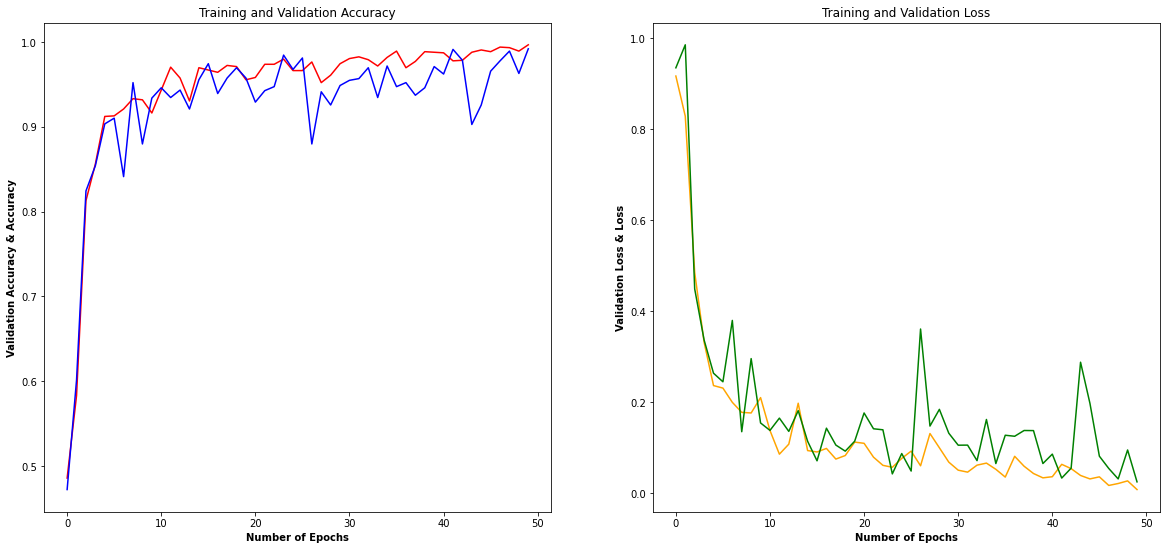

In [ ]:
plt.figure(figsize = (20, 9), linewidth = 1.5)
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = 'Training Accuracy', c = 'red')
plt.plot(range(EPOCHS), validation_accuracy, label = 'Validation Accuracy', c = 'blue')
plt.title('Training and Validation Accuracy')
plt.xlabel('Number of Epochs', fontweight='bold')
plt.ylabel('Validation Accuracy & Accuracy', fontweight='bold')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss', c = 'orange')
plt.plot(range(EPOCHS), validation_loss, label = 'Validation Loss', c = 'green')
plt.title('Training and Validation Loss')
plt.xlabel('Number of Epochs', fontweight='bold')
plt.ylabel('Validation Loss & Loss', fontweight='bold')

plt.show()


#Model Testing

actual label:  Potato___Late_blight
predicted label:  Potato___Late_blight


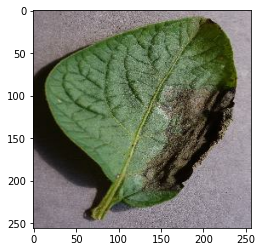

In [ ]:
import numpy as np

for images_batch, labels_batch in test_dataset.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0]

  #print("first image to predict")
  plt.imshow(first_image)
  print("actual label: ", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label: ", class_names[np.argmax(batch_prediction[0])])


In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)  #creating a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence


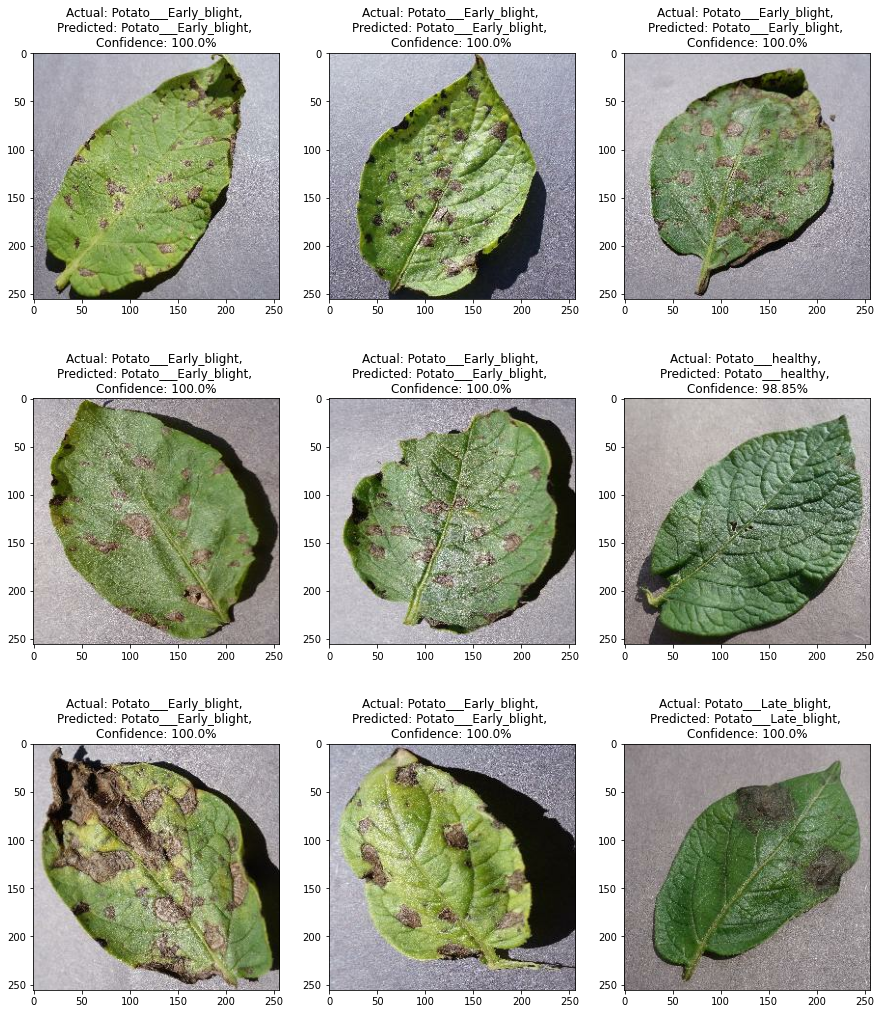

In [ ]:
plt.figure(figsize = (15, 18))
for images, labels in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")


#Saving the best model

In [ ]:
model_version = 1
model.save(f"/content/drive/MyDrive/Potato_Leaf_Dataset/{model_version}")


In [ ]:
model.save("../bestmodel.h5")